## Access Vessel Xbt Realtime Nonqc (Parquet)

This Jupyter notebook demonstrates how to access and plot vessel xbt realtime nonqc data, available as a [Parquet](https://parquet.apache.org) dataset stored on S3.

🔗 More information about the dataset is available [in the AODN metadata catalogue](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/35234913-aa3c-48ec-b9a4-77f822f66ef8).

📌 The source of truth for this notebook is maintained on [GitHub](https://github.com/aodn/aodn_cloud_optimised/tree/main/notebooks/vessel_xbt_realtime_nonqc.ipynb).


In [13]:
dataset_name = "vessel_xbt_realtime_nonqc"

## Install/Update packages and Load common functions

In [6]:
import os, requests, importlib.util

open('setup.py', 'w').write(requests.get('https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/setup.py').text)

spec = importlib.util.spec_from_file_location("setup", "setup.py")
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

setup.install_requirements()
setup.load_dataquery()

Error reading local version: No module named 'aodn_cloud_optimised'
⚠️ Local file has no version or is missing. Downloading remote file.
📥 Wrote updated DataQuery.py


In [8]:
!pip uninstall -y s3fs fsspec
!pip install fsspec==2025.12.0 s3fs==2025.12.0

Found existing installation: s3fs 2026.1.0
Uninstalling s3fs-2026.1.0:
  Successfully uninstalled s3fs-2026.1.0
Found existing installation: fsspec 2026.1.0
Uninstalling fsspec-2026.1.0:
  Successfully uninstalled fsspec-2026.1.0
  Using cached fsspec-2025.12.0-py3-none-any.whl.metadata (10 kB)
  Using cached s3fs-2025.12.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached aiobotocore-2.26.0-py3-none-any.whl.metadata (25 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 2.0.1
    Uninstalling wrapt-2.0.1:
      Successfully uninstalled wrapt-2.0.1
  Attempting uninstall: botocore
    Found existing installation: botocore 1.42.19
    Uninstalling botocore

In [1]:
!pip install --no-deps git+https://github.com/aodn/aodn_cloud_optimised.git

  Cloning https://github.com/aodn/aodn_cloud_optimised.git to /tmp/pip-req-build-0qd29wh2
  Running command git clone --filter=blob:none --quiet https://github.com/aodn/aodn_cloud_optimised.git /tmp/pip-req-build-0qd29wh2
  Resolved https://github.com/aodn/aodn_cloud_optimised.git to commit 00330c0c26488bcaa0684fff18e676796c4bc980
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for aodn-cloud-optimised: filename=aodn_cloud_optimised-0.1.64-py3-none-any.whl size=1043043 sha256=3ce4940909897424727f4f9f083a1f08848214a5c5a51c3d4d0901d6da3609fc
  Stored in directory: /tmp/pip-ephem-wheel-cache-nh099802/wheels/ad/7f/b7/5752e74016133bbab37c5ca0d4e190ec59e52991d354e5f8c3
Successfully built aodn-cloud-optimised


In [4]:
!pip install xmltodict

In [7]:
pip install colorama

  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aodn-cloud-optimised 0.1.64 requires cfunits>=3.3.0, which is not installed.
aodn-cloud-optimised 0.1.64 requires coiled>=1.90.4, which is not installed.
aodn-cloud-optimised 0.1.64 requires dask-cloudprovider>=2025.9.0, which is not installed.
aodn-cloud-optimised 0.1.64 requires dask-expr>=2.0.0, which is not installed.
aodn-cloud-optimised 0.1.64 requires netCDF4==1.6.5, which is not installed.
aodn-cloud-optimised 0.1.64 requires python-levenshtein>=0.25.1, which is not installed.
aodn-cloud-optimised 0.1.64 requires rechunker>=0.5.2, which is not installed.
aodn-cloud-optimised 0.1.64 requires h5py==3.11.0, but you have h5py 3.15.1 which is incompatible.
aodn-cloud-optimised 0.1.64 requires numcodecs<0.16, but you have numcodecs 0.16.5 which 

In [9]:
pip install "dask[distributed]==2025.12.0"

  Using cached distributed-2025.12.0-py3-none-any.whl.metadata (3.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.0 MB/s eta 0:00:00


In [10]:
from DataQuery import GetAodn

# Understanding the Dataset

## Understanding Parquet Partitioning

Parquet files can be **partitioned** by one or more columns, which means the data is physically organised into folders based on the values in those columns. This is similar to how databases use indexes to optimise query performance.

Partitioning enables **faster filtering**: when you query data using a partitioned column, only the relevant subset of files needs to be read—improving performance significantly.

For example, if a dataset is partitioned by `"site_code"`, `"timestamp"`, and `"polygon"`, filtering on `"site_code"` allows the system to skip unrelated files entirely.

In this notebook, the `GetAodn` class includes built-in methods to efficiently filter data by **time** and **latitude/longitude** using the **timestamp** and **polygon** partitions. Other partitions can be used for filtering via the `scalar_filter`.

Any filtering on columns that are **not** partitioned can be significantly slower, as all files may need to be scanned. However, the `GetAodn` class provides a `scalar_filter` method that lets you apply these filters at load time—before the data is fully read—helping reduce the size of the resulting DataFrame.

Once the dataset is loaded, further filtering using Pandas is efficient and flexible.

See further below in the notebook for examples of how to filter the data effectively.

To view the actual partition columns for this dataset, run:


In [14]:
aodn = GetAodn()
dname = f'{dataset_name}.parquet'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 200 ms, sys: 29.1 ms, total: 229 ms
Wall time: 4.55 s


In [ ]:
aodn_dataset.dataset.partitioning.schema

XBT_line: string
timestamp: int32
polygon: string

## List unique partition values

In [20]:
%%time
unique_partition_value = aodn_dataset.get_unique_partition_values('XBT_line')
print(list(unique_partition_value))  # showing a subset only

['PX34', 'IX28', 'PX32', 'PX06', 'PX30-31']
CPU times: user 20.3 ms, sys: 704 µs, total: 21 ms
Wall time: 22.6 ms


## Visualise Spatial Extent of the dataset
This section plots the polygons representing the areas where data is available. It helps to identify and create a bounding box around the regions containing data.

In [19]:
help(aodn_dataset)

Help on ParquetDataSource in module DataQuery object:

class ParquetDataSource(DataSource)
 |  ParquetDataSource(bucket_name: str, prefix: str, dataset_name: str, s3_fs_opts: dict | None = None)
 |
 |  DataSource implementation for Parquet datasets.
 |
 |  Method resolution order:
 |      ParquetDataSource
 |      DataSource
 |      abc.ABC
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self, bucket_name: str, prefix: str, dataset_name: str, s3_fs_opts: dict | None = None)
 |      Initialises the ParquetDataSource with optional S3 filesystem overrides.
 |
 |  get_data(self, date_start: str | None = None, date_end: str | None = None, lat_min: float | None = None, lat_max: float | None = None, lon_min: float | None = None, lon_max: float | None = None, scalar_filter: dict | None = None, columns: list[str] | None = None, lat_varname: str | None = None, lon_varname: str | None = None, time_varname: str | None = None) -> pandas.core.frame.DataFrame
 |      Retrieves da

/usr/local/lib/python3.12/dist-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://na

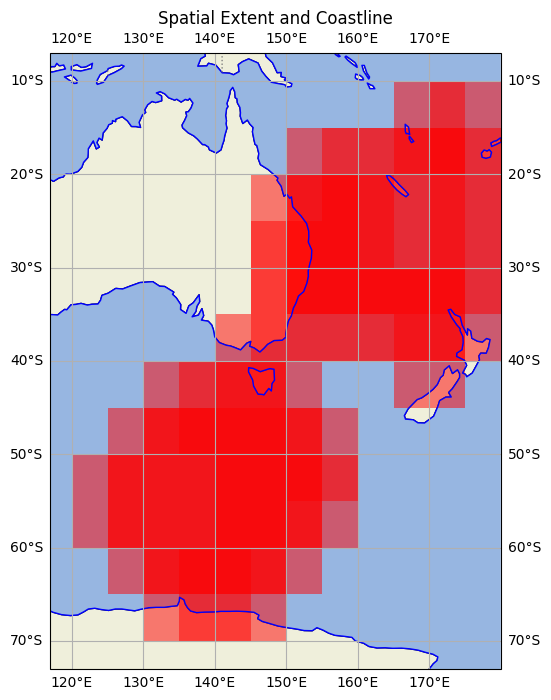

In [21]:
aodn_dataset.plot_spatial_extent()

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [22]:
aodn_dataset.get_temporal_extent()

(Timestamp('2020-09-01 13:46:59.999999744'), Timestamp('2024-06-23 18:13:00'))

## Read Metadata

For all Parquet datasets, we create a sidecar file named **_common_metadata** in the root of the dataset. This file contains both the dataset-level and variable-level attributes.  
The metadata can be retrieved below as a dictionary, and it will also be included in the pandas DataFrame when using the `get_data` method from the `GetAodn` class.

In [23]:
metadata = aodn_dataset.get_metadata()
metadata

2026-01-15 02:31:32,797 - aodn.GetAodn - INFO - Retrieving metadata for aodn-cloud-optimised/vessel_xbt_realtime_nonqc.parquet


{'TIME': {'type': 'timestamp[ns]',
  'standard_name': 'time',
  'long_name': 'time',
  'axis': 'T',
  'valid_min': 0.0,
  'valid_max': 90000.0},
 'LATITUDE': {'type': 'double',
  'standard_name': 'latitude',
  'long_name': 'latitude',
  'units': 'degrees_north',
  'axis': 'Y',
  'valid_min': -90.0,
  'valid_max': 90.0,
  'reference_datum': 'WGS84 coordinate reference system'},
 'LONGITUDE': {'type': 'double',
  'standard_name': 'longitude',
  'long_name': 'longitude',
  'units': 'degrees_east',
  'axis': 'X',
  'valid_min': -180.0,
  'valid_max': 180.0,
  'reference_datum': 'WGS84 coordinate reference system'},
 'DEPTH': {'type': 'double',
  'axis': 'Z',
  'long_name': 'depth',
  'positive': 'down',
  'reference_datum': 'sea surface',
  'standard_name': 'depth',
  'units': 'm',
  'ancillary_variables': 'DEPTH_quality_control',
  'valid_max': 12000.0,
  'valid_min': -5.0,
  'fallrate_equation_coefficient_a': 6.691,
  'fallrate_equation_coefficient_b': -2.25},
 'DEPTH_quality_control': {

# Data Query and Plot

## Create a TIME and BoundingBox filter

This cell loads a subset of the dataset based on a time range and a spatial bounding box. The result is returned as a pandas DataFrame, and basic information about its structure is displayed.

In [25]:
help(aodn_dataset.get_data)

Help on method get_data in module DataQuery:

get_data(date_start: str | None = None, date_end: str | None = None, lat_min: float | None = None, lat_max: float | None = None, lon_min: float | None = None, lon_max: float | None = None, scalar_filter: dict | None = None, columns: list[str] | None = None, lat_varname: str | None = None, lon_varname: str | None = None, time_varname: str | None = None) -> pandas.core.frame.DataFrame method of DataQuery.ParquetDataSource instance
    Retrieves data from the Parquet dataset, applying filters.

    Constructs PyArrow filter expressions based on the provided time range,
    bounding box, and scalar filter conditions. Reads the filtered data

    Args:
        date_start: Start date string (e.g., "YYYY-MM-DD").
        date_end: End date string (e.g., "YYYY-MM-DD"). Defaults to now if
            `date_start` is provided but `date_end` is None.
        lat_min: Minimum latitude for bounding box filter.
        lat_max: Maximum latitude for bound

In [24]:
%%time
df = aodn_dataset.get_data(date_start='2020-09-01 13:47:00', date_end='2024-06-23 18:13:00')
df.info()

2026-01-15 02:37:13,149 - aodn.GetAodn - INFO - Retrieving metadata for aodn-cloud-optimised/vessel_xbt_realtime_nonqc.parquet


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3608768 entries, 0 to 3608767
Data columns (total 14 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   TIME                   datetime64[ns]
 1   LATITUDE               float64       
 2   LONGITUDE              float64       
 3   DEPTH                  float64       
 4   DEPTH_quality_control  float32       
 5   TEMP                   float64       
 6   TEMP_quality_control   float32       
 7   imo_number             int32         
 8   ship_name              object        
 9   Callsign               object        
 10  filename               object        
 11  XBT_line               object        
 12  timestamp              int32         
 13  polygon                object        
dtypes: datetime64[ns](1), float32(2), float64(4), int32(2), object(5)
memory usage: 330.4+ MB
CPU times: user 11.7 s, sys: 4.39 s, total: 16.1 s
Wall time: 4min 42s


In [ ]:
## Download Subsetted Data as CSV

# This cell downloads the filtered dataset as a ZIP-compressed CSV file.
# The CSV includes metadata at the top as commented lines, and a `FileLink` object is returned to allow downloading directly from the notebook.


df.aodn.download_as_csv()

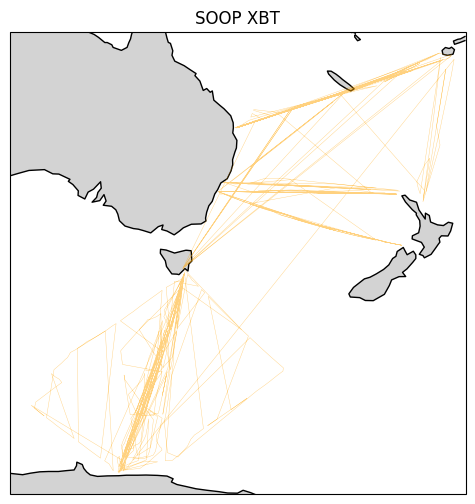

In [29]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines(resolution="110m")
ax.add_feature(cfeature.LAND, facecolor="lightgray")

plt.plot(
    df["LONGITUDE"],
    df["LATITUDE"],
    color="orange",
    alpha=0.5,
    linewidth=0.3
)

ax.set_title("SOOP XBT")
plt.show()

fig.savefig("xbt_tracks_map.svg", format="svg", bbox_inches="tight")

In [30]:
!ls /content

DataQuery.py  __pycache__  sample_data	setup.py  xbt_tracks_map.svg


In [31]:
from google.colab import files
files.download("/content/xbt_tracks_map.svg")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>